# Objectifs : 
1. Accéder au information du compte binance (fees taker/maker)
2. Accéder à la composition du portefeuille spot et tracer un pie chart de cette composition
3. Accéder au total en $ du portefeuille (earn / spot )

In [5]:
# Libraries 
from binance.client import Client
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
# Connect to binance API
INPUT_FILE= "API_KEYS.txt"

with open(INPUT_FILE, 'r', encoding='utf-8') as file:
    contenu_liste = file.read()

KEYS = contenu_liste.split(',')
KEYS = [element.strip() for element in KEYS]

api_key = KEYS[0]
api_secret = KEYS[1]
client = Client(api_key,api_secret)

In [7]:
info = client.get_account()

# Commission Rates
maker_rate = float(info['commissionRates']['maker'])
taker_rate = float(info['commissionRates']['taker'])

# Convert to seconds (Python's datetime uses seconds)
date_sec = info['updateTime'] / 1000 

# Format the timestamp into a readable date
formatted_date = datetime.fromtimestamp(date_sec, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')

# Impression avec alignement
output = (
    f"{'Binance account':<15} : SCL\n"
    f"{'Date':<15} : {formatted_date:<10}\n"
    f"{'Maker Rate':<15} : {maker_rate:<10.3f}\n"
    f"{'Taker Rate':<15} : {taker_rate:<10.3f}"
)

print(output)

Binance account : SCL
Date            : 2024-12-27 03:07:37
Maker Rate      : 0.001     
Taker Rate      : 0.001     


In [8]:
# Accéder à la composition du portefeuille binance 
df_account_crypto = pd.DataFrame(info['balances'])

# Convert 'free' column to numeric
df_account_crypto['free'] = pd.to_numeric(df_account_crypto['free'])

# Filter rows where 'free' > 0
df_account_crypto = df_account_crypto[df_account_crypto['free'] > 0]

# Remove the 'locked' column
df_account_crypto = df_account_crypto.drop(columns=['locked'])

# Supprimer les lignes où 'asset' est 'ETHW' ou 'LDUSDC'
df_account_crypto = df_account_crypto[~df_account_crypto['asset'].isin(['ETHW', 'LDUSDC'])]

REFERENCE = 'USDT'
df_account_crypto["pair"] = df_account_crypto["asset"] + REFERENCE 

# Fonction personnalisée pour appliquer les formules
def apply_formula(row):
    if row['asset'] == REFERENCE:
        return row['free'] * 1
    else:
        return row['free'] * float(client.get_avg_price(symbol=row['pair'])['price'])

# Appliquer la fonction pour créer la nouvelle colonne 'value_in_usdt'
df_account_crypto['reference'] = df_account_crypto.apply(apply_formula, axis=1)

# Sort
df_account_crypto = df_account_crypto.sort_values(by='reference', ascending=False)
# Calcul du pourcentage de chaque ligne par rapport au total de la colonne 'reference'
total_reference = df_account_crypto['reference'].sum()
df_account_crypto['percentage_of_total'] = (df_account_crypto['reference'] / total_reference) * 100

# Désactiver la notation scientifique pour l'affichage
df_account_crypto['percentage_of_total'] = df_account_crypto['percentage_of_total'].apply(lambda x: '{:.1f}'.format(x))

df_account_crypto

,asset,free,pair,reference,percentage_of_total
0,BTC,0.006044,BTCUSDT,571.120214,50.9
239,SOL,1.998000,SOLUSDT,369.706057,33.0
11,USDT,176.265309,USDTUSDT,176.265309,15.7
4,BNB,0.004669,BNBUSDT,3.225413,0.3
158,USDC,0.739710,USDCUSDT,0.740791,0.1
545,PEPE,0.160000,PEPEUSDT,0.000003,0.0


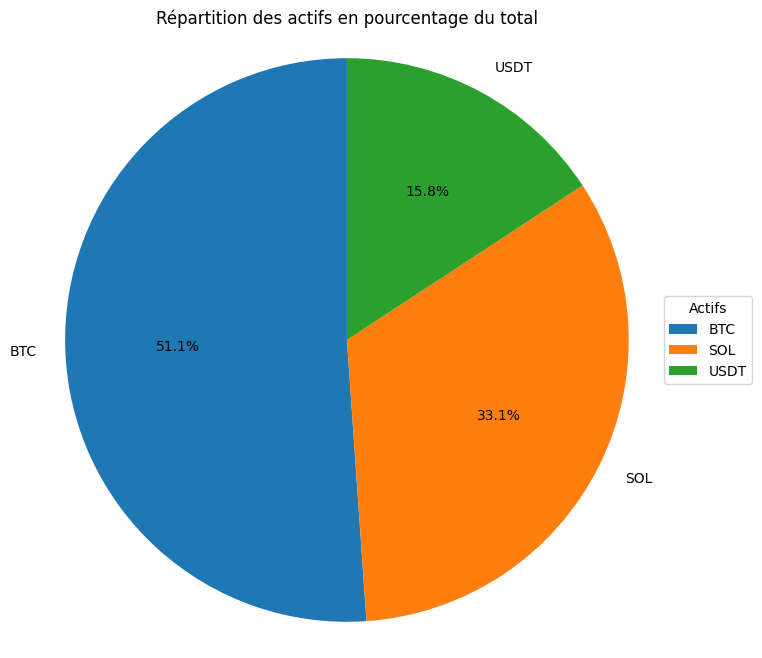

In [9]:
# Filtrer les actifs dont la valeur est inférieure à 1%
df_account_crypto['percentage_of_total'] = df_account_crypto['percentage_of_total'].astype(float)
filtered_df = df_account_crypto[df_account_crypto['percentage_of_total'] >= 1]

# Créer un pie chart pour les actifs filtrés
plt.figure(figsize=(8, 8))  # Taille du graphique
plt.pie(filtered_df['percentage_of_total'], labels=filtered_df['asset'], autopct='%1.1f%%', startangle=90)

# Ajouter un titre
plt.title('Répartition des actifs en pourcentage du total')

# Afficher la légende uniquement pour les actifs avec un pourcentage >= 1%
plt.legend(filtered_df['asset'], title='Actifs', loc='center left', bbox_to_anchor=(1, 0.5))

# Afficher le graphique
plt.axis('equal')  # Assure que le pie chart est un cercle
plt.show()

In [18]:
# Binance Earn 
savings_data = client.get_simple_earn_account()

# Impression avec alignement
output = (
    f"{'Binance Earn $':<15} : {float(savings_data['totalAmountInUSDT']):<10.2f}\n"
    f"{'Binance Spot $':<15} : {df_account_crypto['reference'].sum():<10.2f}\n"
    f"{'Binance Total $':<15} : {df_account_crypto['reference'].sum() + float(savings_data['totalAmountInUSDT']):<10.2f}\n"
    
)

print(output)

Binance Earn $  : 1003.43   
Binance Spot $  : 1121.06   
Binance Total $ : 2124.48   

